In [15]:
import os
import pandas as pd
import numpy as np

# Specify the base directory for the experiment results (10000000 size)
base_dir = "/home/igor/igor_repos/noise_scaling_laws/Scaling-up-measurement-noise-scaling-laws/analysis/outputs/2025-12-07_23-21_evaluate_all_shendure_geneformer_models_on_mid_quality_data"

# The dataset, size, and relevant signals
experiment_configs = {
    "shendure": (10000000,
                 [1.0, 0.5414548, 0.2931733, 0.1587401, 0.0859506, 0.0465384, 0.0251984, 0.0136438, 0.0073875, 0.004],
                 ["author_day"])
}

records = []

for dataset, (size, bvalues, signals) in experiment_configs.items():
    for bvalue in bvalues:
        for signal in signals:
            seed = 42
            algo = "Geneformer"
            path_new = f"{base_dir}/{dataset}/{size}/{bvalue}/results/{algo}/model/MI/{seed}/Y_{signal}_{bvalue}_{algo.lower()}"
            file_original_compare_to_mi = os.path.join(path_new, "lmi_mutual_information.txt")
            path_old = f"{base_dir}/{dataset}/{size}/{bvalue}/results/{algo}/model/MI/{seed}/Y_{signal}_1.0_{algo.lower()}"
            file_new_experiment_results = os.path.join(path_old, "lmi_mutual_information.txt")

            if os.path.exists(file_original_compare_to_mi):
                try:
                    with open(file_original_compare_to_mi, "r") as f:
                        lmi_original_compare_to_mi = f.read().strip()
                except Exception:
                    lmi_original_compare_to_mi = None
            else:
                lmi_original_compare_to_mi = None

            if os.path.exists(file_new_experiment_results):
                try:
                    with open(file_new_experiment_results, "r") as f:
                        lmi_new_experiment_results = f.read().strip()
                except Exception:
                    lmi_new_experiment_results = None
            else:
                lmi_new_experiment_results = None

            records.append({
                "dataset": dataset,
                "size": size,
                "bvalue": bvalue,
                "signal": signal,
                "algorithm": algo,
                "seed": seed,
                "lmi_new_high_quality_eval": lmi_new_experiment_results,
                "lmi_original_same_quality_eval": lmi_original_compare_to_mi
            })

mi_fs_df = pd.DataFrame(records)

if 'seed' in mi_fs_df.columns:
    mi_fs_df = mi_fs_df.drop(columns=['seed'])
if 'umis_per_cell' in mi_fs_df.columns:
    mi_fs_df = mi_fs_df.drop(columns=['umis_per_cell'])

# If you have a CSV or other result to compare, load it here (or set mi_csv_df to an empty df if not available)
mi_csv_df = pd.DataFrame()
# Optionally, if you want to compare to a previous CSV, you can load it like this:
# mi_csv_df = pd.read_csv("/path/to/previous_results.csv")
# mi_csv_df = mi_csv_df.rename(columns={'quality': 'bvalue'})

# Type cast for merging
mi_fs_df['signal'] = mi_fs_df['signal'].astype(str)
mi_fs_df['algorithm'] = mi_fs_df['algorithm'].astype(str)
if not mi_csv_df.empty:
    mi_csv_df['signal'] = mi_csv_df['signal'].astype(str)
    mi_csv_df['algorithm'] = mi_csv_df['algorithm'].astype(str)

# Merge if applicable
if not mi_csv_df.empty:
    merged_df = pd.merge(
        mi_fs_df,
        mi_csv_df,
        how='left',
        on=['dataset', 'size', 'bvalue', 'signal', 'algorithm'],
        suffixes=('', '_csv')
    )
else:
    merged_df = mi_fs_df

# Remove rows with NaN in any of the "lmi" relevant columns
# Convert to numeric to standardize "None" and empty to np.nan
merged_df['lmi_new_high_quality_eval'] = pd.to_numeric(merged_df['lmi_new_high_quality_eval'], errors='coerce')
merged_df['lmi_original_same_quality_eval'] = pd.to_numeric(merged_df['lmi_original_same_quality_eval'], errors='coerce')
merged_df = merged_df.dropna(subset=['lmi_new_high_quality_eval', 'lmi_original_same_quality_eval'])

merged_df


,dataset,size,bvalue,signal,algorithm,lmi_new_high_quality_eval,lmi_original_same_quality_eval
0,shendure,10000000,1.000000,author_day,Geneformer,1.92699,1.92699
1,shendure,10000000,0.541455,author_day,Geneformer,1.85850,1.79979
2,shendure,10000000,0.293173,author_day,Geneformer,2.05358,2.01080
3,shendure,10000000,0.158740,author_day,Geneformer,1.89000,1.90433
4,shendure,10000000,0.085951,author_day,Geneformer,1.77112,1.73928
5,shendure,10000000,0.046538,author_day,Geneformer,1.75417,1.70319
6,shendure,10000000,0.025198,author_day,Geneformer,1.54535,1.51149
7,shendure,10000000,0.013644,author_day,Geneformer,1.42805,1.38629
8,shendure,10000000,0.007387,author_day,Geneformer,1.23391,1.18816
9,shendure,10000000,0.004000,author_day,Geneformer,1.09154,1.07646


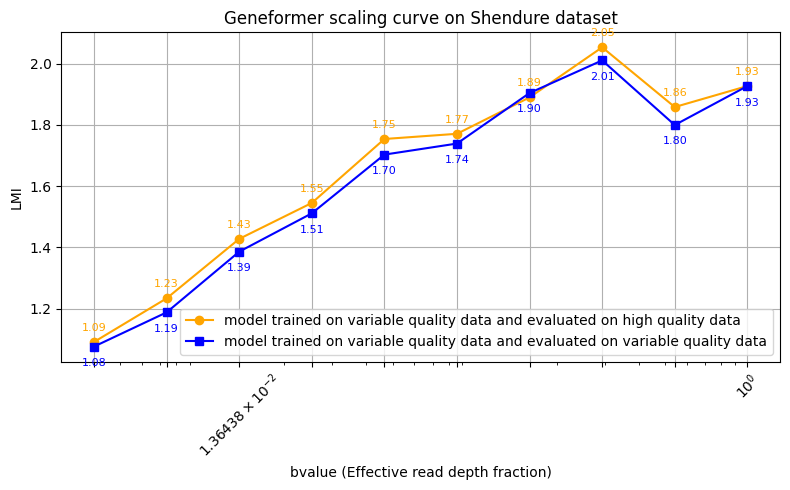

In [16]:
import matplotlib.pyplot as plt

# Only select rows for shendure, just in case we have more datasets in the future
df = merged_df[merged_df['dataset'] == 'shendure'].copy()

# For plotting, ensure the bvalue is sorted descending (from 1.0 to low)
df = df.sort_values('bvalue', ascending=False)

# Convert None and missing/NaN to np.nan for plotting
def safe_float(x):
    try:
        if x is None:
            return float('nan')
        return float(x)
    except Exception:
        return float('nan')

df['lmi_new_high_quality_eval'] = df['lmi_new_high_quality_eval'].apply(safe_float)
df['lmi_original_same_quality_eval'] = df['lmi_original_same_quality_eval'].apply(safe_float)

plt.figure(figsize=(8, 5))

# Connect the points with lines and plot points with only 2 decimals in annotation
plt.plot(df['bvalue'], df['lmi_new_high_quality_eval'], color='orange', marker='o', linestyle='-', label='model trained on variable quality data and evaluated on high quality data')
plt.plot(df['bvalue'], df['lmi_original_same_quality_eval'], color='blue', marker='s', linestyle='-', label='model trained on variable quality data and evaluated on variable quality data')

# Add value annotation for each point, colored accordingly and rounded to 2 decimals
for i, (x, y) in enumerate(zip(df['bvalue'], df['lmi_new_high_quality_eval'])):
    plt.annotate(f"{y:.2f}", (x, y), textcoords="offset points", xytext=(0,8), ha='center', color='orange', fontsize=8)

for i, (x, y) in enumerate(zip(df['bvalue'], df['lmi_original_same_quality_eval'])):
    plt.annotate(f"{y:.2f}", (x, y), textcoords="offset points", xytext=(0,-14), ha='center', color='blue', fontsize=8)

plt.xlabel('bvalue (Effective read depth fraction)')
plt.ylabel('LMI')
plt.title('Geneformer scaling curve on Shendure dataset')
plt.legend()
plt.grid(True)
plt.xscale('log')
plt.xticks(df['bvalue'], rotation=45)
plt.tight_layout()
plt.show()
